In [1]:
# import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import operator
import itertools

In [48]:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 

In [112]:
from torch.distributions.categorical import Categorical
a=torch.tensor([ 0.9, 0.1, 0.0, 0.0 ])
b=torch.tensor([ 0.0, 0.1, 0.9, 0.0 ])
c=a.repeat(5).view(5,4)
d=b.repeat(5).view(5,4)
yo=torch.stack((c,d))
print('yo',yo.size())
m = Categorical(probs=a)
hey=Categorical(probs=yo)
sample=m.sample([2,5,3]).view(2,15)
print(sample.size())
one_hot_samples=one_hot_embedding(sample,4)
print('one_hot_size',one_hot_samples.size())
prob=yo@one_hot_samples.permute(0,2,1)
print('prob',prob.size())
print(torch.mean(prob,dim=1))

g=sample_from_batch_categorical_multiple_cpu(yo,sample_num=300)
print('g',g.size())

first_cat=Categorical(probs=c)
second_cat=Categorical(probs=d)
for i in sample[0]:
    a=torch.mean(torch.exp(first_cat.log_prob(i)))
    print(a)
print('ha')
for i in sample[1]:
    a=torch.mean(torch.exp(second_cat.log_prob(i)))
    print(a)

yo torch.Size([2, 5, 4])
torch.Size([2, 15])
one_hot_size torch.Size([2, 15, 4])
prob torch.Size([2, 5, 15])
tensor([[0.9000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.9000, 0.1000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
g torch.Size([2, 5, 300])
tensor(0.9000)
tensor(0.9000)
tensor(0.1000)
tensor(0.9000)
tensor(0.9000)
tensor(0.9000)
tensor(0.9000)
tensor(0.1000)
tensor(0.9000)
tensor(0.9000)
tensor(0.9000)
tensor(0.9000)
tensor(0.9000)
tensor(0.9000)
tensor(0.9000)
ha
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(0.1000)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)
tensor(1.1921e-07)


In [32]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [33]:
train_data_list=[]
train_label_list=[]
for x,y in train_data:
    train_data_list.append(x)
    train_label_list.append(y)
    
test_data_list=[]
test_label_list=[]
for x,y in test_data:
    test_data_list.append(x)
    test_label_list.append(y)
    
train_data_tensor=torch.stack(train_data_list)
train_label_tensor=torch.tensor(train_label_list)
test_data_tensor=torch.stack(test_data_list)
test_label_tensor=torch.tensor(test_label_list)

print(train_data_tensor.size())
print(train_label_tensor.size())
print(test_data_tensor.size())
print(test_label_tensor.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [34]:
print(train_data_tensor[0:2].size())

torch.Size([2, 1, 28, 28])


In [121]:
class Net(nn.Module):
    def __init__(self,feature_dim):
        super(Net, self).__init__()
        self.feature_dim=feature_dim        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, feature_dim)
        self.fc3 = nn.Linear(feature_dim,10)
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =torch.tanh(self.fc2(x))
        x= self.fc3(x)
        return F.log_softmax(x,dim=-1)
        
    def predictive_distribution_entropy(self,x):
        with torch.no_grad():
            batch_logit=self.forward(x)
            batch_probs=torch.exp(batch_logit)
            batch_entropy=-torch.sum(batch_logit*batch_probs,dim=-1)
#             print(batch_entropy.size())
        return batch_entropy

        
    
    def train(self,x,label):
        train_losses = []
        batch_size=100
        for epoch in range(0,1000):
            if epoch%100==0:
                print('learning_epoch:',epoch)
            for it in range(0,int(x.size(0)/batch_size)):
                index=np.random.choice(x.size(0),batch_size)
                self.optimizer.zero_grad()
                output = self.forward(x[index])
                nll_loss= F.nll_loss(output,label[index],reduction='sum')
                nll_loss.backward()
                self.optimizer.step()
                train_losses.append(nll_loss.item())
        plt.title('training_accuracy')
        plt.plot(train_losses)
        plt.show()
        return train_losses
    
    def test(self,x,label):
        correct=0
        pred = (self.forward(x).data.max(dim=1, keepdim=True)[1]).view(-1)
#         print(pred)
#         print(label)
#         print(torch.nonzero(pred-label))
        accuracy=(pred == label).sum().item()/label.size(0)
        return accuracy
    
        
#     def test(self):
#         correct=0
#         for data, target in test_loader:
#             pred = self.predict(data)
#             correct += pred.eq(target.data.view_as(pred)).sum()
#             correct_ratio= float(correct)/len(test_loader.dataset)
#         return correct_ratio
    

big_epoch: 0 start training...
train_data_size 100
learning_epoch: 0
learning_epoch: 100
learning_epoch: 200
learning_epoch: 300
learning_epoch: 400
learning_epoch: 500
learning_epoch: 600
learning_epoch: 700
learning_epoch: 800
learning_epoch: 900


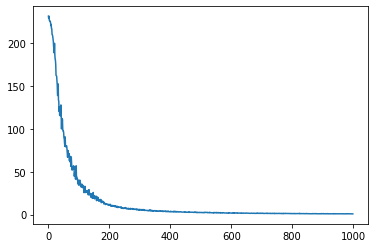

epoch: 0 test_accuracy 0.7576


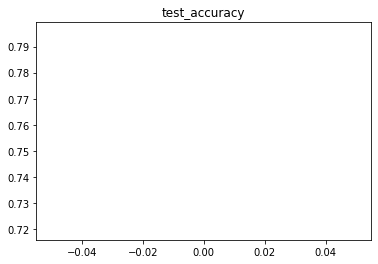

epoch: 0 start active learning...
60 active_iterations
120 active_iterations
180 active_iterations
240 active_iterations
300 active_iterations
360 active_iterations
420 active_iterations
480 active_iterations
540 active_iterations
big_epoch: 1 start training...
train_data_size 699
learning_epoch: 0
learning_epoch: 100
learning_epoch: 200
learning_epoch: 300
learning_epoch: 400
learning_epoch: 500
learning_epoch: 600
learning_epoch: 700
learning_epoch: 800
learning_epoch: 900


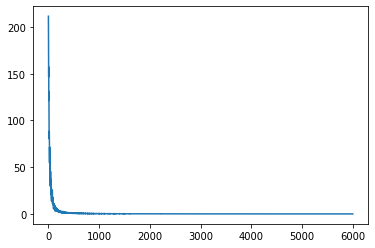

epoch: 1 test_accuracy 0.938


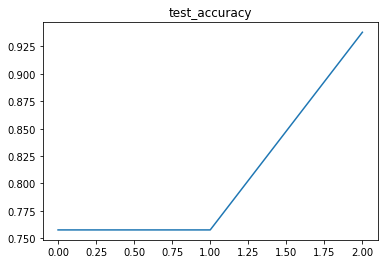

epoch: 1 start active learning...
60 active_iterations
120 active_iterations
180 active_iterations
240 active_iterations
300 active_iterations
360 active_iterations
420 active_iterations
480 active_iterations
540 active_iterations
big_epoch: 2 start training...
train_data_size 1298
learning_epoch: 0
learning_epoch: 100
learning_epoch: 200
learning_epoch: 300
learning_epoch: 400
learning_epoch: 500
learning_epoch: 600
learning_epoch: 700
learning_epoch: 800
learning_epoch: 900


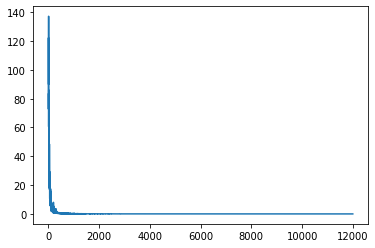

epoch: 2 test_accuracy 0.9723


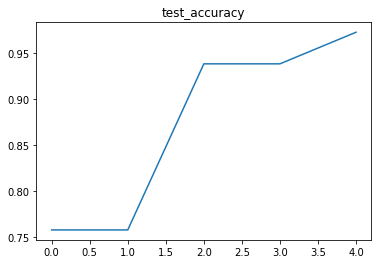

epoch: 2 start active learning...
60 active_iterations
120 active_iterations
180 active_iterations
240 active_iterations
300 active_iterations
360 active_iterations
420 active_iterations
480 active_iterations
540 active_iterations
big_epoch: 3 start training...
train_data_size 1897
learning_epoch: 0
learning_epoch: 100


In [ ]:
nn_tanh = Net(feature_dim=20)
init_train_data=train_data_tensor[0:100]
init_train_label=train_label_tensor[0:100]
accuracy_list=[]
for epoch in range(0,100):
    print('big_epoch:', epoch, 'start training...')
    print('train_data_size',init_train_label.size(0))
    nn_tanh.train(init_train_data,init_train_label)
    
    accuracy=nn_tanh.test(test_data_tensor,test_label_tensor)
    accuracy_list.append(accuracy)
    print('epoch:', epoch, 'test_accuracy', accuracy)
    plt.title('test_accuracy')
    plt.plot(accuracy_list)
    plt.show()
    accuracy_list.append(accuracy)
    ### active part
    print('epoch:', epoch, 'start active learning...')
    for i in range(1,600):
        if i %60 ==0:
            print(i,'active_iterations')
        active_batch_data=train_data_tensor[i*100:(i+1)*100]
        entropy_list=nn_tanh.predictive_distribution_entropy(active_batch_data)
        _, index = entropy_list.max(0)
        init_train_data=torch.cat((init_train_data,active_batch_data[index].view(1,1,28,28)),0)
        init_train_label=torch.cat((init_train_label,train_label_tensor[index+i*100].view(-1)),0)